# Longitudinal Data → NetLogo Complexity Model Pipeline

This notebook provides a **complete end-to-end pipeline** from normalized time series data to a fully functional NetLogo agent-based model with polynomial interactions.

## Pipeline Overview

1. **Data Loading & Exploration**
2. **Stationarity Testing** (ADF, KPSS)
3. **Variable Selection** (top N by importance)
4. **Granger Causality Analysis** (pairwise)
5. **VAR Estimation** (Vector Autoregression)
6. **VECM Estimation** (Vector Error Correction Model)
7. **Coefficient Extraction**
8. **NetLogo Model Generation** (with polynomial interactions)
9. **Write Complete .nlogo File**

## Requirements

- **Input**: Normalized longitudinal multivariate data (Excel/CSV); Normalized data should z-score normally distributed data ranges and log exponentially growing data. Even relative sizes or growths should be normalized with z-scores.
- **Output**: Executable NetLogo 6.4 model (.nlogo file)

## Generic Design

This notebook is designed to work with **ANY** normalized time series dataset. Simply configure the parameters below and run all cells.

---

## Section 0: Configuration

**Configure these parameters for your dataset:**

In [108]:
# ============================================================================
# USER CONFIGURATION
# ============================================================================

# Data file path (Excel or CSV with normalized data)
DATA_FILE = 'C:/Users/zachh/Downloads/MTS_Search/MTS_Search/Dataset/Flight001.csv'

# Time column name (e.g., 'Year', 'Date', 'FY')
TIME_COLUMN = 'time'

# Number of top variables to select for VECM
TOP_N_VARIABLES = 8

# Maximum lag order to test. Lag is the steps waited before influence. Lag 5, written as VAR(5) test lags 1-5. If you were testing data by FY, then VAR(5) 
#would cover a 5 year lag. Generally more variables means lower lag to avoid over-parameterization or over-fitting the model.
MAX_LAG = 5

# Granger causality significance level; this should remain at .05 unless you really know what you're doing.
GRANGER_ALPHA = 0.05

# Output directory for results
OUTPUT_DIR = 'NetLogo_Model_Output'

# NetLogo model metadata
MODEL_NAME = 'Time_Series_VECM_Model'
MODEL_DESCRIPTION = 'Agent-based model generated from VAR/VECM analysis of longitudinal data'
AUTHOR = 'Auto-generated'

# Polynomial interaction settings
INCLUDE_SECOND_ORDER = True  # Add X*Y interaction terms
INCLUDE_THIRD_ORDER = True   # Add X*Y*Z interaction terms

print(f"Configuration loaded for: {DATA_FILE}")
print(f"Top {TOP_N_VARIABLES} variables will be selected")
print(f"Output will be saved to: {OUTPUT_DIR}/")

Configuration loaded for: C:/Users/zachh/Downloads/MTS_Search/MTS_Search/Dataset/Flight001.csv
Top 8 variables will be selected
Output will be saved to: NetLogo_Model_Output/


## Section 1: Import Libraries

In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path
import os

# Statistical testing
from statsmodels.tsa.stattools import adfuller, kpss, grangercausalitytests
from statsmodels.tsa.api import VAR
from statsmodels.tsa.vector_ar.vecm import coint_johansen, VECM

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


## Section 2: Data Loading & Exploration

In [110]:
# Create output directory
Path(OUTPUT_DIR).mkdir(exist_ok=True)

# Load data
if DATA_FILE.endswith('.xlsx'):
    df_raw = pd.read_excel(DATA_FILE)
elif DATA_FILE.endswith('.csv'):
    df_raw = pd.read_csv(DATA_FILE)
else:
    raise ValueError("Data file must be .xlsx or .csv")

print(f"Data loaded: {df_raw.shape[0]} observations, {df_raw.shape[1]} columns")
print(f"\nTime range: {df_raw[TIME_COLUMN].min()} to {df_raw[TIME_COLUMN].max()}")
print(f"\nFirst few rows:")
df_raw.head()

Data loaded: 4780 observations, 30 columns

Time range: 0.0 to 4802.9

First few rows:


,time,alt,MN,TRA,Wf,Fn,SmHPC,SmLPC,SmFan,T48,...,phi,Ps30,NfR,NcR,BPR,farB,htBleed,PCNfRdmd,W31,W32
0,0.000,0.0,0.000000,0.0000,1.3799,18073,36.564,7.5386,5.1091,1283.6,...,28.903,171.88,1258.3,7449.6,9.4495,0.013078,282.29,48.000,16.487,9.8924
1,1.005,0.0,0.004546,1.8182,1.3804,17848,36.556,7.5393,5.1151,1283.7,...,28.909,171.90,1258.3,7449.6,9.4512,0.013081,282.30,49.345,16.488,9.8928
2,2.010,0.0,0.009114,3.6455,1.3805,17630,36.556,7.5396,5.1252,1283.7,...,28.908,171.91,1258.3,7449.6,9.4550,0.013081,282.30,50.696,16.490,9.8938
3,3.015,0.0,0.013682,5.4727,1.3809,17416,36.554,7.5394,5.1384,1283.8,...,28.915,171.93,1258.3,7449.6,9.4600,0.013084,282.30,52.048,16.491,9.8949
4,4.020,0.0,0.018250,7.3000,1.4652,17695,35.451,7.7880,5.2477,1310.4,...,29.866,176.61,1269.2,7465.1,9.3931,0.013670,284.21,53.400,16.748,10.0490


In [111]:
# Extract time index and separate endogenous/exogenous variables
time_index = df_raw[TIME_COLUMN].values

# Get all numeric columns
all_numeric_cols = df_raw.select_dtypes(include=[np.number]).columns.tolist()

# Remove excluded columns
all_numeric_cols = [col for col in all_numeric_cols if col not in EXCLUDE_COLUMNS]

# Separate endogenous and exogenous
endogenous_cols = [col for col in all_numeric_cols if col not in EXOGENOUS_VARS]
exogenous_cols = [col for col in all_numeric_cols if col in EXOGENOUS_VARS]

print(f"Endogenous variables: {len(endogenous_cols)}")
print(f"Exogenous variables: {len(exogenous_cols)}")
print(f"\nEndogenous: {endogenous_cols[:5]}...")
print(f"Exogenous: {exogenous_cols}")

Endogenous variables: 30
Exogenous variables: 0

Endogenous: ['time', 'alt', 'MN', 'TRA', 'Wf']...
Exogenous: []


## Section 3: Stationarity Testing

In [112]:
def test_stationarity(series, var_name):
    """Run ADF and KPSS tests for stationarity."""
    # Drop NaN values
    series_clean = series.dropna()
    
    if len(series_clean) < 10:
        return {'variable': var_name, 'adf_pvalue': np.nan, 'kpss_pvalue': np.nan, 
                'stationary': False, 'transformation': 'insufficient_data'}
    
    # ADF test (H0: unit root exists)
    adf_result = adfuller(series_clean, autolag='AIC')
    adf_pvalue = adf_result[1]
    
    # KPSS test (H0: series is stationary)
    kpss_result = kpss(series_clean, regression='c', nlags='auto')
    kpss_pvalue = kpss_result[1]
    
    # Determine stationarity
    # Stationary if: ADF rejects H0 (p < 0.05) AND KPSS fails to reject H0 (p > 0.05)
    stationary = (adf_pvalue < 0.05) and (kpss_pvalue > 0.05)
    
    # Suggest transformation
    if stationary:
        transformation = 'none'
    elif adf_pvalue >= 0.05:
        transformation = 'differencing'
    else:
        transformation = 'check_manually'
    
    return {
        'variable': var_name,
        'adf_pvalue': adf_pvalue,
        'kpss_pvalue': kpss_pvalue,
        'stationary': stationary,
        'transformation': transformation
    }

# Test all endogenous variables
stationarity_results = []
for col in endogenous_cols:
    result = test_stationarity(df_raw[col], col)
    stationarity_results.append(result)

df_stationarity = pd.DataFrame(stationarity_results)
df_stationarity.to_excel(f'{OUTPUT_DIR}/stationarity_tests.xlsx', index=False)

print(f"Stationarity testing complete: {df_stationarity['stationary'].sum()} / {len(endogenous_cols)} variables are stationary")
print(f"\nNon-stationary variables requiring transformation:")
df_stationarity[~df_stationarity['stationary']][['variable', 'transformation']]

Stationarity testing complete: 1 / 30 variables are stationary

Non-stationary variables requiring transformation:


,variable,transformation
0,time,differencing
1,alt,differencing
2,MN,differencing
3,TRA,differencing
4,Wf,differencing
5,Fn,differencing
6,SmHPC,differencing
7,SmLPC,differencing
8,SmFan,differencing
9,T48,differencing


## Section 4: Variable Selection (Top N by Importance)

Top 8 variables selected:
  1. Fn
  2. alt
  3. time
  4. Nc
  5. T48
  6. Nf
  7. NfR
  8. P30


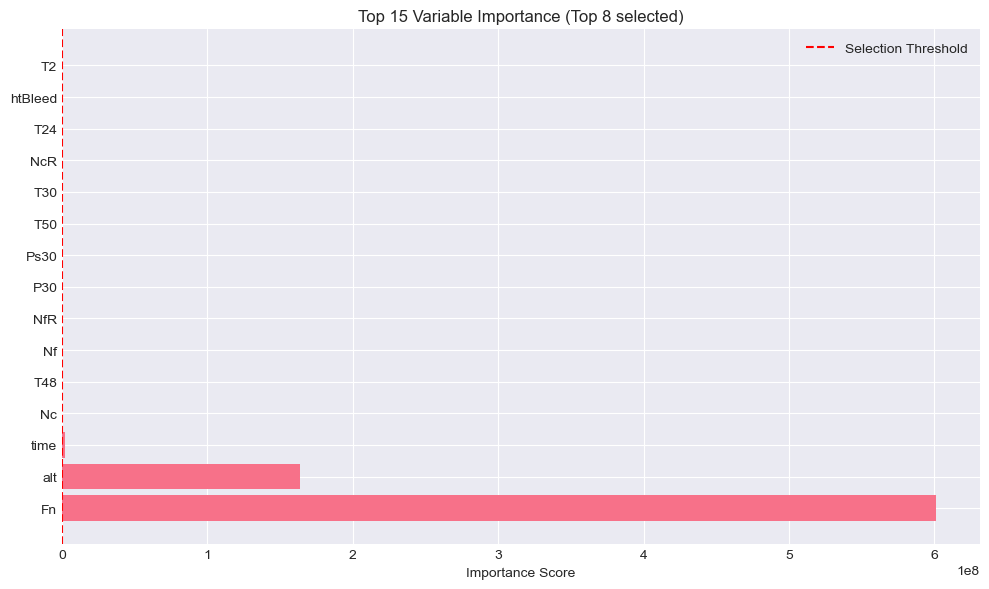

In [113]:
def calculate_variable_importance(df, variables):
    """Calculate variable importance based on correlation network centrality."""
    df_vars = df[variables].dropna()
    
    # Correlation matrix
    corr_matrix = df_vars.corr().abs()
    
    # Network centrality: sum of absolute correlations
    importance = corr_matrix.sum(axis=1) - 1  # Subtract self-correlation
    
    # Variance as secondary importance measure
    variance = df_vars.var()
    
    # Combined importance score
    importance_df = pd.DataFrame({
        'variable': variables,
        'correlation_centrality': importance.values,
        'variance': variance.values,
        'combined_score': importance.values + variance.values
    })
    
    return importance_df.sort_values('combined_score', ascending=False)

# Calculate importance and select top N
importance_df = calculate_variable_importance(df_raw, endogenous_cols)
selected_vars = importance_df.head(TOP_N_VARIABLES)['variable'].tolist()

importance_df.to_excel(f'{OUTPUT_DIR}/variable_importance.xlsx', index=False)

print(f"Top {TOP_N_VARIABLES} variables selected:")
for i, var in enumerate(selected_vars, 1):
    print(f"  {i}. {var}")

# Visualize importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df.head(15)['variable'], importance_df.head(15)['combined_score'])
plt.xlabel('Importance Score')
plt.title(f'Top 15 Variable Importance (Top {TOP_N_VARIABLES} selected)')
plt.axvline(x=importance_df.iloc[TOP_N_VARIABLES-1]['combined_score'], color='r', linestyle='--', label='Selection Threshold')
plt.legend()
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/variable_importance.png', dpi=300, bbox_inches='tight')
plt.show()

## Section 5: Prepare Data for VAR/VECM

In [114]:
# Extract selected variables
df_selected = df_raw[selected_vars].dropna()

# Extract exogenous variables if present
if exogenous_cols:
    df_exog = df_raw[exogenous_cols].loc[df_selected.index]
else:
    df_exog = None

print(f"Data prepared: {len(df_selected)} observations, {len(selected_vars)} endogenous variables")
print(f"Exogenous variables: {len(exogenous_cols) if exogenous_cols else 0}")

Data prepared: 4780 observations, 8 endogenous variables
Exogenous variables: 0


## Section 6: Pairwise Granger Causality

In [115]:
#when you have a lot of variables, more than makes sense for the VAR, Granger causality test will determine which
#variables are the most influential so you can reduce variables down to the 6-8 normal for VAR analysis. Alternatively,
#you can run a sparse VAR or Graphical VAR to determine variable network layout and variable centrality to pick your top 6-8, 
#though this has less precision
def pairwise_granger_causality(df, variables, max_lag=5, alpha=0.05):
    """Test Granger causality for all variable pairs."""
    results = []
    
    for i, var_x in enumerate(variables):
        for j, var_y in enumerate(variables):
            if i == j:
                continue
            
            # Test if X Granger-causes Y
            try:
                data_pair = df[[var_y, var_x]].dropna()
                if len(data_pair) < max_lag + 10:
                    continue
                
                test_result = grangercausalitytests(data_pair, max_lag, verbose=False)
                
                # Extract p-values for all lags
                pvalues = [test_result[lag+1][0]['ssr_ftest'][1] for lag in range(max_lag)]
                min_pvalue = min(pvalues)
                best_lag = pvalues.index(min_pvalue) + 1
                
                # Significant if any lag has p < alpha
                significant = min_pvalue < alpha
                
                if significant:
                    results.append({
                        'cause': var_x,
                        'effect': var_y,
                        'best_lag': best_lag,
                        'p_value': min_pvalue,
                        'significant': significant
                    })
            except Exception as e:
                continue
    
    return pd.DataFrame(results)

# Run Granger causality tests
print("Running pairwise Granger causality tests...")
df_granger = pairwise_granger_causality(df_selected, selected_vars, MAX_LAG, GRANGER_ALPHA)
df_granger = df_granger.sort_values('p_value')
df_granger.to_excel(f'{OUTPUT_DIR}/granger_causality.xlsx', index=False)

print(f"\nGranger causality analysis complete: {len(df_granger)} significant relationships found")
print(f"\nTop 10 strongest causal relationships:")
df_granger.head(10)

Running pairwise Granger causality tests...

Granger causality analysis complete: 42 significant relationships found

Top 10 strongest causal relationships:


,cause,effect,best_lag,p_value,significant
25,T48,NfR,2,0.000000e+00,True
24,T48,Nf,2,0.000000e+00,True
23,T48,Nc,2,0.000000e+00,True
22,T48,Fn,3,0.000000e+00,True
11,time,alt,1,3.471956e-231,True
26,T48,P30,5,2.877023e-174,True
28,Nf,Nc,4,1.115710e-166,True
33,NfR,Nc,4,5.029986e-148,True
37,P30,Fn,3,2.991616e-136,True
40,P30,Nf,4,2.937021e-129,True


## Section 7: VAR Model Estimation

In [116]:
# Fit VAR model
var_model = VAR(df_selected)

# Select optimal lag order
lag_order_results = var_model.select_order(maxlags=MAX_LAG)
optimal_lag = lag_order_results.aic

print(f"Optimal lag order (AIC): {optimal_lag}")
print(f"\nLag order selection criteria:")
print(lag_order_results.summary())

# Fit VAR with optimal lag
var_fitted = var_model.fit(optimal_lag)

# Save VAR summary
with open(f'{OUTPUT_DIR}/var_summary.txt', 'w') as f:
    f.write(str(var_fitted.summary()))

print(f"\nVAR({optimal_lag}) model fitted successfully")

Optimal lag order (AIC): 5

Lag order selection criteria:
 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0       78.85       78.86   1.758e+34       78.86
1     -0.2079     -0.1103      0.8123     -0.1736
2      -15.04      -14.85   2.948e-07      -14.97
3      -16.89      -16.62   4.608e-08      -16.80
4      -17.39      -17.04   2.793e-08      -17.27
5     -17.51*     -17.07*  2.480e-08*     -17.36*
-------------------------------------------------

VAR(5) model fitted successfully


In [117]:
# Extract VAR coefficients
var_coefs = var_fitted.params
var_coefs.to_excel(f'{OUTPUT_DIR}/var_coefficients.xlsx')

print("VAR coefficients extracted:")
print(f"Shape: {var_coefs.shape}")
var_coefs.head(10)

VAR coefficients extracted:
Shape: (41, 8)


,Fn,alt,time,Nc,T48,Nf,NfR,P30
const,2378.282579,68.548756,1.379128,156.124060,36.442461,61.596134,64.014991,31.138149
L1.Fn,1.237781,-0.005602,-0.000015,-0.014230,-0.008468,-0.016945,-0.016433,-0.004397
L1.alt,-0.946956,2.203257,-0.000139,-0.012400,-0.003497,-0.017262,-0.014213,-0.001642
L1.time,-29.378735,-0.829622,0.928886,-1.082352,-1.230527,-0.546754,-0.519610,-0.441545
L1.Nc,-32.188813,-0.025954,0.000004,0.728963,-0.354149,-0.118969,-0.071352,-0.463985
L1.T48,24.121940,0.158378,0.000339,0.885074,1.371833,0.513898,0.517625,0.163764
L1.Nf,37.641007,-0.642438,0.002082,0.819278,0.118307,1.591304,0.530589,0.366301
L1.NfR,-23.275360,0.311701,-0.002158,-0.297687,0.138416,0.497497,1.553009,-0.205062
L1.P30,152.749335,0.775278,-0.000377,3.247539,2.821877,2.068914,1.826467,3.304169
L2.Fn,0.358983,0.008780,-0.000012,0.024209,0.009117,0.030177,0.029471,0.007636


## Section 8: VECM Model Estimation (Cointegration)

In [118]:
# VAR data is differenced so that each year acts independently and can be used to calculate the next year,
# this loses any long-term trend analysis and cointegration/VECM detects these trends and reintroduces them to the model.
# Test for cointegration using Johansen test
def johansen_cointegration_test(data, det_order=0, k_ar_diff=1):
    """Run Johansen cointegration test."""
    result = coint_johansen(data, det_order=det_order, k_ar_diff=k_ar_diff)
    
    # Trace statistic test
    trace_stat = result.lr1
    trace_crit = result.cvt[:, 1]  # 5% critical values
    
    # Determine cointegration rank
    coint_rank = 0
    for i in range(len(trace_stat)):
        if trace_stat[i] > trace_crit[i]:
            coint_rank = i + 1
    
    return result, coint_rank

# Run Johansen test
print("Testing for cointegration...")
johansen_result, coint_rank = johansen_cointegration_test(df_selected, det_order=0, k_ar_diff=max(1, optimal_lag-1))

print(f"\nCointegration rank: {coint_rank}")
print(f"Number of cointegrating relationships: {coint_rank}")

# Save cointegration results
with open(f'{OUTPUT_DIR}/cointegration_test.txt', 'w') as f:
    f.write(f"Johansen Cointegration Test\n")
    f.write(f"=" * 50 + "\n")
    f.write(f"Cointegration rank: {coint_rank}\n\n")
    f.write(f"Trace statistics:\n{johansen_result.lr1}\n\n")
    f.write(f"Critical values (5%):\n{johansen_result.cvt[:, 1]}\n")

Testing for cointegration...

Cointegration rank: 2
Number of cointegrating relationships: 2


In [119]:
# Fit VECM model
if coint_rank > 0:
    print(f"\nFitting VECM with {coint_rank} cointegrating relationships...")
    
    vecm_lag = max(1, optimal_lag - 1)
    vecm_model = VECM(df_selected, k_ar_diff=vecm_lag, coint_rank=coint_rank, deterministic='ci')
    vecm_fitted = vecm_model.fit()
    
    # Save VECM summary
    with open(f'{OUTPUT_DIR}/vecm_summary.txt', 'w') as f:
        f.write(str(vecm_fitted.summary()))
    
    print("VECM model fitted successfully")
    
    # Extract key components
    alpha = vecm_fitted.alpha  # Error correction coefficients
    beta = vecm_fitted.beta    # Cointegrating vectors
    gamma = vecm_fitted.gamma  # Short-run coefficients (like VAR)
    
    # Save components
    pd.DataFrame(alpha, index=selected_vars, 
                 columns=[f'eq_{i+1}' for i in range(coint_rank)]).to_excel(f'{OUTPUT_DIR}/vecm_alpha.xlsx')
    pd.DataFrame(beta, index=selected_vars, 
                 columns=[f'eq_{i+1}' for i in range(coint_rank)]).to_excel(f'{OUTPUT_DIR}/vecm_beta.xlsx')
    
    print(f"\nError correction coefficients (alpha) shape: {alpha.shape}")
    print(f"Cointegrating vectors (beta) shape: {beta.shape}")
else:
    print("\nNo cointegration found - VECM not applicable")
    vecm_fitted = None
    alpha = None
    beta = None


Fitting VECM with 2 cointegrating relationships...
VECM model fitted successfully

Error correction coefficients (alpha) shape: (8, 2)
Cointegrating vectors (beta) shape: (8, 2)


## Section 9: Extract Coefficients for NetLogo Model

In [120]:
# Organize all coefficients for NetLogo generation
netlogo_data = {
    'variables': selected_vars,
    'n_vars': len(selected_vars),
    'time_column': TIME_COLUMN,
    'time_start': int(time_index[0]),
    'time_end': int(time_index[-1]),
    'optimal_lag': optimal_lag,
    'coint_rank': coint_rank,
    'granger_relationships': df_granger.to_dict('records'),
    'var_coefficients': var_coefs.to_dict(),
    'alpha': alpha.tolist() if alpha is not None else None,
    'beta': beta.tolist() if beta is not None else None,
    'exogenous_vars': exogenous_cols
}

print("Coefficients extracted for NetLogo model:")
print(f"  - {len(selected_vars)} endogenous variables")
print(f"  - {len(df_granger)} Granger causal relationships")
print(f"  - {coint_rank} cointegrating equations")
print(f"  - VAR lag order: {optimal_lag}")

Coefficients extracted for NetLogo model:
  - 8 endogenous variables
  - 42 Granger causal relationships
  - 2 cointegrating equations
  - VAR lag order: 5


## Section 10: Generate NetLogo Model Code

In [121]:
#I'll be honest, I used claude AI to convert the coefficients into a netlogo model in the following few sections, I understand in vague terms
#what is happening and can correct an error, but I could recreate the below code on my own. It does work and usuallycreates stable models.
def sanitize_varname(name):
    """Convert variable name to valid NetLogo identifier."""
    # Replace invalid characters
    name = name.replace(' ', '-')
    name = name.replace('_', '-')
    name = name.replace('(', '')
    name = name.replace(')', '')
    name = name.replace('/', '-')
    name = name.lower()
    return name

# Create NetLogo variable names
nl_varnames = [sanitize_varname(v) for v in selected_vars]
var_mapping = dict(zip(selected_vars, nl_varnames))

print("NetLogo variable mapping:")
for orig, nl in list(var_mapping.items())[:5]:
    print(f"  {orig} → {nl}")
print(f"  ... ({len(var_mapping)} total variables)")

NetLogo variable mapping:
  Fn → fn
  alt → alt
  time → time
  Nc → nc
  T48 → t48
  ... (8 total variables)


In [122]:
def generate_netlogo_globals(nl_varnames, optimal_lag, coint_rank):
    """Generate NetLogo globals section."""
    code = "globals [\n"
    code += "  ; === TIME SERIES VARIABLES (normalized) ===\n"
    for var in nl_varnames:
        code += f"  {var}\n"
    
    code += "\n  ; === LAG VARIABLES ===\n"
    for lag in range(1, optimal_lag + 1):
        code += f"  ; Lag {lag}\n"
        for var in nl_varnames:
            code += f"  lag{lag}-{var}\n"
    
    if coint_rank > 0:
        code += "\n  ; === EQUILIBRIUM & ERROR CORRECTION ===\n"
        for eq in range(coint_rank):
            code += f"  equilibrium-{eq+1}\n"
            code += f"  error-{eq+1}\n"
    
    code += "\n  ; === TIME TRACKING ===\n"
    code += "  year\n"
    code += "  tick-count\n"
    
    code += "\n  ; === HISTORY TRACKING ===\n"
    for var in nl_varnames:
        code += f"  history-{var}\n"
    
    code += "\n  ; === CORRELATED SHOCKS ===\n"
    for var in nl_varnames:
        code += f"  shock-{var}\n"
    
    code += "]\n"
    return code

netlogo_globals = generate_netlogo_globals(nl_varnames, optimal_lag, coint_rank)
print("NetLogo globals section generated")
print(netlogo_globals[:500] + "...")

NetLogo globals section generated
globals [
  ; === TIME SERIES VARIABLES (normalized) ===
  fn
  alt
  time
  nc
  t48
  nf
  nfr
  p30

  ; === LAG VARIABLES ===
  ; Lag 1
  lag1-fn
  lag1-alt
  lag1-time
  lag1-nc
  lag1-t48
  lag1-nf
  lag1-nfr
  lag1-p30
  ; Lag 2
  lag2-fn
  lag2-alt
  lag2-time
  lag2-nc
  lag2-t48
  lag2-nf
  lag2-nfr
  lag2-p30
  ; Lag 3
  lag3-fn
  lag3-alt
  lag3-time
  lag3-nc
  lag3-t48
  lag3-nf
  lag3-nfr
  lag3-p30
  ; Lag 4
  lag4-fn
  lag4-alt
  lag4-time
  lag4-nc
  lag4-t48
  lag4-nf
  lag4-n...


In [123]:
def generate_setup_procedure(nl_varnames, time_start):
    """Generate NetLogo setup procedure."""
    code = "to setup\n"
    code += "  clear-all\n"
    code += "  reset-ticks\n\n"
    
    code += f"  set year {time_start}\n"
    code += "  set tick-count 0\n\n"
    
    code += "  ; Initialize all variables to 0 (normalized baseline)\n"
    for var in nl_varnames:
        code += f"  set {var} 0\n"
    
    code += "\n  ; Initialize lag variables\n"
    code += "  update-lags\n\n"
    
    code += "  ; Initialize history lists\n"
    for var in nl_varnames:
        code += f"  set history-{var} []\n"
    code += "  record-history\n\n"
    
    code += "  setup-patches\n"
    code += "end\n\n"
    
    code += "to setup-patches\n"
    code += "  ask patches [ set pcolor white ]\n"
    code += "end\n"
    
    return code

netlogo_setup = generate_setup_procedure(nl_varnames, netlogo_data['time_start'])
print("Setup procedure generated")

Setup procedure generated


In [124]:
def generate_update_lags(nl_varnames, optimal_lag):
    """Generate procedure to update lag variables."""
    code = "to update-lags\n"
    
    # Shift lags: lag2 <- lag1 <- current
    for lag in range(optimal_lag, 1, -1):
        code += f"  ; Shift lag{lag-1} to lag{lag}\n"
        for var in nl_varnames:
            code += f"  set lag{lag}-{var} lag{lag-1}-{var}\n"
    
    code += "  ; Shift current to lag1\n"
    for var in nl_varnames:
        code += f"  set lag1-{var} {var}\n"
    
    code += "end\n"
    return code

netlogo_lags = generate_update_lags(nl_varnames, optimal_lag)
print("Lag update procedure generated")

Lag update procedure generated


In [125]:
def generate_error_correction(nl_varnames, alpha, beta, coint_rank):
    """Generate error correction procedure."""
    if alpha is None or beta is None or coint_rank == 0:
        return "; No cointegration - error correction not applicable\n"
    
    code = "to apply-error-correction\n"
    code += "  ; Calculate equilibrium deviations\n"
    for eq in range(coint_rank):
        code += f"  set equilibrium-{eq+1} ("
        terms = []
        for i, var in enumerate(nl_varnames):
            coef = beta[i, eq]
            if abs(coef) > 0.01:  # Only include significant coefficients
                terms.append(f"({coef:.3f} * {var})")
        code += " + ".join(terms)
        code += ")\n"
        code += f"  set error-{eq+1} equilibrium-{eq+1}\n"
    
    code += "\n  ; Apply error correction - FIXED: Actually apply the corrections!\n"
    for i, var in enumerate(nl_varnames):
        correction_terms = []
        for eq in range(coint_rank):
            alpha_coef = alpha[i, eq]
            if abs(alpha_coef) > 0.01:
                correction_terms.append(f"({alpha_coef:.3f} * error-correction-strength * error-{eq+1} * 0.01)")
        
        if correction_terms:
            code += f"  set {var} {var} + " + " + ".join(correction_terms) + "\n"
    
    code += "end\n"
    return code

netlogo_error_correction = generate_error_correction(nl_varnames, alpha, beta, coint_rank)
print("Error correction procedure generated")

Error correction procedure generated


In [126]:
def generate_var_dynamics(nl_varnames, granger_df, var_mapping):
    """Generate VAR dynamics from Granger causality relationships."""
    code = "to apply-var-dynamics\n"
    code += "  ; VAR dynamics based on Granger causality\n"
    code += "  let vs var-strength\n\n"
    
    for idx, row in granger_df.iterrows():
        cause = var_mapping[row['cause']]
        effect = var_mapping[row['effect']]
        lag = int(row['best_lag'])
        
        # Assign coefficient (simplified - use 0.3 as placeholder)
        coef = 0.3 if row['p_value'] < 0.01 else 0.2
        
        code += f"  ; {row['cause']} → {row['effect']}\n"
        code += f"  set {effect} {effect} + ({coef:.2f} * vs * lag{lag}-{cause} * 0.01)\n\n"
    
    code += "end\n"
    return code

netlogo_var = generate_var_dynamics(nl_varnames, df_granger, var_mapping)
print("VAR dynamics procedure generated")
print(f"Implemented {len(df_granger)} Granger causal relationships")

VAR dynamics procedure generated
Implemented 42 Granger causal relationships


In [127]:
def generate_polynomial_interactions(nl_varnames):
    """Generate polynomial interaction terms."""
    code = "to apply-polynomial-interactions\n"
    code += "  if not use-interactions? [ stop ]\n\n"
    code += "  let vs var-strength\n"
    code += "  let is interaction-strength\n\n"
    
    code += "  ; === SECOND-ORDER INTERACTIONS ===\n"
    # Generate some example second-order interactions
    n = len(nl_varnames)
    count = 0
    for i in range(min(3, n)):
        for j in range(i+1, min(i+3, n)):
            if count >= 8:  # Limit to 8 interactions
                break
            var_i = nl_varnames[i]
            var_j = nl_varnames[j]
            target = nl_varnames[(i+j) % n]
            
            coef = 0.1
            code += f"  ; {var_i} × {var_j} → {target}\n"
            code += f"  set {target} {target} + (lag1-{var_i} * lag1-{var_j} * {coef:.2f} * vs * is * 0.01)\n\n"
            count += 1
    
    code += "  ; === THIRD-ORDER INTERACTIONS ===\n"
    code += "  if is > 0.3 [\n"
    # Generate some example third-order interactions
    count = 0
    for i in range(min(2, n)):
        for j in range(i+1, min(i+2, n)):
            for k in range(j+1, min(j+2, n)):
                if count >= 5:  # Limit to 5 interactions
                    break
                var_i = nl_varnames[i]
                var_j = nl_varnames[j]
                var_k = nl_varnames[k]
                target = nl_varnames[(i+j+k) % n]
                
                coef = 0.05
                code += f"    ; {var_i} × {var_j} × {var_k} → {target}\n"
                code += f"    set {target} {target} + (lag1-{var_i} * lag1-{var_j} * lag1-{var_k} * {coef:.2f} * vs * is * 0.01)\n\n"
                count += 1
    code += "  ]\n"
    
    code += "end\n"
    return code

if INCLUDE_SECOND_ORDER or INCLUDE_THIRD_ORDER:
    netlogo_interactions = generate_polynomial_interactions(nl_varnames)
    print("Polynomial interactions generated")
else:
    netlogo_interactions = "; Polynomial interactions disabled\n"
    print("Polynomial interactions disabled")

Polynomial interactions generated


In [128]:
def generate_clipping_procedure(nl_varnames):
    """Generate variable clipping for numerical stability."""
    code = "to clip-variables\n"
    code += "  ; Clip all variables to prevent overflow\n"
    for var in nl_varnames:
        code += f"  if {var} > 15 [ set {var} 15 ]\n"
        code += f"  if {var} < -15 [ set {var} -15 ]\n"
    code += "end\n"
    return code

netlogo_clipping = generate_clipping_procedure(nl_varnames)
print("Clipping procedure generated")

Clipping procedure generated


In [129]:
def generate_go_procedure():
    """Generate main simulation loop."""
    code = "to go\n"
    code += "  if max-year > 0 and year >= max-year [ stop ]\n\n"
    
    code += "  update-lags\n"
    code += "  apply-error-correction\n"
    code += "  apply-var-dynamics\n"
    code += "  apply-polynomial-interactions\n"
    code += "  add-noise\n"
    code += "  clip-variables\n\n"
    
    code += "  set year year + 1\n"
    code += "  set tick-count tick-count + 1\n"
    code += "  record-history\n"
    code += "  tick\n"
    code += "end\n"
    return code

netlogo_go = generate_go_procedure()
print("Main loop procedure generated")

Main loop procedure generated


In [130]:
def generate_utility_procedures(nl_varnames):
    """Generate utility procedures."""
    code = "to add-noise\n"
    for var in nl_varnames:
        code += f"  set {var} {var} + random-normal 0 (noise-level * 0.01)\n"
    code += "end\n\n"
    
    code += "to record-history\n"
    for var in nl_varnames:
        code += f"  set history-{var} lput {var} history-{var}\n"
    code += "end\n"
    
    return code

netlogo_utils = generate_utility_procedures(nl_varnames)
print("Utility procedures generated")

Utility procedures generated


In [131]:
def generate_interface_section(nl_varnames, time_start, time_end):
    """Generate NetLogo interface (sliders, monitors, plots)."""
    code = "@#$#@#$#@\n"
    
    # Graphics window
    code += """GRAPHICS-WINDOW
210
10
647
448
-1
-1
13.0
1
10
1
1
1
0
1
1
1
-16
16
-16
16
0
0
1
ticks
30.0

"""
    
    # Setup and Go buttons
    code += """BUTTON
15
15
88
48
Setup
setup
NIL
1
T
OBSERVER
NIL
NIL
NIL
NIL
1

BUTTON
95
15
168
48
Go
go
T
1
T
OBSERVER
NIL
NIL
NIL
NIL
1

"""
    
    # Key sliders
    code += """SLIDER
15
95
200
128
error-correction-strength
error-correction-strength
0
2
1.0
0.1
1
NIL
HORIZONTAL

SLIDER
15
135
200
168
var-strength
var-strength
0
2
1.0
0.1
1
NIL
HORIZONTAL

SLIDER
15
175
200
208
noise-level
noise-level
0
5
1.0
0.5
1
NIL
HORIZONTAL

SLIDER
15
215
200
248
interaction-strength
interaction-strength
0
1
0.5
0.1
1
NIL
HORIZONTAL

SLIDER
15
255
200
288
max-year
max-year
0
2100
0
10
1
NIL
HORIZONTAL

SWITCH
15
295
200
328
use-interactions?
use-interactions?
0
1
-1000

"""
    
    # Year monitor
    code += """MONITOR
670
15
750
60
Year
year
0
1
11

"""
    
    # Add monitors for ALL variables (in 2 columns)
    monitor_y = 70
    for i, var in enumerate(nl_varnames):
        col = i % 2
        row = i // 2
        x1 = 670 + (col * 90)
        x2 = x1 + 80
        y1 = monitor_y + (row * 50)
        y2 = y1 + 45
        
        # Capitalize first letter for display
        label = var.capitalize()
        
        code += f"""MONITOR
{x1}
{y1}
{x2}
{y2}
{label}
{var}
3
1
11

"""
    
    # Plot with EXACT color encoding format from working DoD file
    # Using the same negative RGB integer format
    distinct_colors = [
        -13345367,  # Red-ish (from DoD: Junior Enlisted)
        -2674135,   # Orange-ish (from DoD: Field Grade Officers)
        -955883,    # Brown-ish (from DoD: GOFOs)
        -13840069,  # Blue-ish (from DoD: Total Civilians)
        -8630108,   # Green-ish (from DoD: Policy Count)
        -5825686,   # Purple-ish (from DoD: Total PAS)
        -7500403,   # Cyan-ish (from DoD: FOIA Days)
        -2674135,   # Orange again (reuse for 8th)
        -955883,    # Brown again
        -13345367,  # Red again
        -13840069,  # Blue again
        -8630108    # Green again
    ]
    
    code += f"""PLOT
15
460
850
650
All Variables
Tick
Value (normalized)
0.0
40.0
-3.0
3.0
true
true
"" ""
PENS
"""
    for i, var in enumerate(nl_varnames):
        color = distinct_colors[i % len(distinct_colors)]
        label = var.capitalize()
        code += f'"{label}" 1.0 0 {color} true "" "plot {var}"\n'
    
    code += "\n"
    code += "@#$#@#$#@\n"
    return code

netlogo_interface = generate_interface_section(nl_varnames, netlogo_data['time_start'], netlogo_data['time_end'])
print("Interface section generated with monitors and plot using EXACT color format from working DoD file")

Interface section generated with monitors and plot using EXACT color format from working DoD file


## Section 11: Assemble Complete NetLogo Model

In [132]:
# Assemble all sections - FIXED: Must have exactly 12 sections with Unix (LF) line endings
# Section order: 0=Code, 1=Interface, 2=Info, 3=Shapes, 4=Version, 5-7=Empty, 8=Empty, 9=Link shapes, 10=Settings, 11=Empty
netlogo_full_model = f"""; {'=' * 80}
; {MODEL_NAME}
; Auto-generated from VAR/VECM Analysis
; {'=' * 80}
;
; {MODEL_DESCRIPTION}
;
; Data: {DATA_FILE}
; Time period: {netlogo_data['time_start']} to {netlogo_data['time_end']}
; Variables: {len(selected_vars)}
; Granger relationships: {len(df_granger)}
; Cointegration rank: {coint_rank}
; VAR lag order: {optimal_lag}
;
; Author: {AUTHOR}
; {'=' * 80}

{netlogo_globals}

; {'=' * 80}
; SETUP PROCEDURES
; {'=' * 80}

{netlogo_setup}

; {'=' * 80}
; MAIN SIMULATION LOOP
; {'=' * 80}

{netlogo_go}

; {'=' * 80}
; LAG UPDATE
; {'=' * 80}

{netlogo_lags}

; {'=' * 80}
; ERROR CORRECTION (VECM)
; {'=' * 80}

{netlogo_error_correction}

; {'=' * 80}
; VAR DYNAMICS (Granger Causality)
; {'=' * 80}

{netlogo_var}

; {'=' * 80}
; POLYNOMIAL INTERACTIONS
; {'=' * 80}

{netlogo_interactions}

; {'=' * 80}
; NUMERICAL STABILITY
; {'=' * 80}

{netlogo_clipping}

; {'=' * 80}
; UTILITY PROCEDURES
; {'=' * 80}

{netlogo_utils}
{netlogo_interface}
"""

# Add standard NetLogo footer sections - CRITICAL: Section order matters!
# Sections 5, 6, 7, 8 must be empty, then section 9 is link shapes
netlogo_full_model += """## WHAT IS IT?

This model was automatically generated from Vector Autoregression (VAR) and Vector Error Correction Model (VECM) analysis of longitudinal time series data.

## HOW IT WORKS

The model implements:
1. Error correction mechanisms (VECM)
2. Short-run VAR dynamics
3. Granger causal relationships
4. Polynomial interactions (second and third order)
5. Numerical stability through variable clipping

## HOW TO USE IT

1. Click Setup to initialize
2. Adjust sliders to control model dynamics
3. Click Go to run simulation

## CREDITS

Auto-generated by data_to_netlogo_pipeline.ipynb
@#$#@#$#@
default
true
0
Polygon -7500403 true true 150 5 40 250 150 205 260 250
@#$#@#$#@
NetLogo 6.4.0
@#$#@#$#@
@#$#@#$#@
@#$#@#$#@
@#$#@#$#@
@#$#@#$#@
default
0.0
-0.2 0 0.0 1.0
0.0 1 1.0 0.0
0.2 0 0.0 1.0
link direction
true
0
Line -7500403 true 150 150 90 180
Line -7500403 true 150 150 210 180
@#$#@#$#@
0
@#$#@#$#@
"""

print(f"\nComplete NetLogo model generated ({len(netlogo_full_model)} characters)")


Complete NetLogo model generated (12720 characters)


## Section 12: Write NetLogo File

In [133]:
# Write to .nlogo file - FIXED: Use Unix (LF) line endings, not Windows (CRLF)
output_filename = f"{OUTPUT_DIR}/{MODEL_NAME}.nlogo"

with open(output_filename, 'w', encoding='utf-8', newline='\n') as f:
    f.write(netlogo_full_model)

print(f"\n{'='*80}")
print(f"SUCCESS! NetLogo model generated:")
print(f"{'='*80}")
print(f"\nFile: {output_filename}")
print(f"Size: {len(netlogo_full_model):,} characters")
print(f"\nModel components:")
print(f"  - {len(selected_vars)} endogenous variables")
print(f"  - {len(df_granger)} Granger causal relationships")
print(f"  - {coint_rank} cointegrating equations")
print(f"  - VAR lag order: {optimal_lag}")
print(f"  - Polynomial interactions: {'Enabled' if INCLUDE_SECOND_ORDER else 'Disabled'}")
print(f"\nCRITICAL: File uses Unix (LF) line endings - required for NetLogo 6.4!")
print(f"You can now open this file in NetLogo 6.4!")
print(f"{'='*80}")


SUCCESS! NetLogo model generated:

File: NetLogo_Model_Output/Time_Series_VECM_Model.nlogo
Size: 12,720 characters

Model components:
  - 8 endogenous variables
  - 42 Granger causal relationships
  - 2 cointegrating equations
  - VAR lag order: 5
  - Polynomial interactions: Enabled

CRITICAL: File uses Unix (LF) line endings - required for NetLogo 6.4!
You can now open this file in NetLogo 6.4!
